In [3]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.3         magrittr_2.0.3          presto_1.0.0           
 [4] harmony_1.2.0           Rcpp_1.0.12             ggrepel_0.9.4          
 [7] ggridges_0.5.5          ggpubr_0.6.0            Biostrings_2.70.1      
[10] GenomeInfoDb_1.38.2     XVector_0.42.0          IRanges_2.36.0         
[13] S4Vectors_0.40.2        BiocGenerics_0.48.1     lubridate_1.9.3        
[16] forcats_

# Load Libraries

In [2]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods) # github install
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(RColorBrewer)
   library(pheatmap)
    library(Matrix)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(dendsort)
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    library(harmony) #github install immunogenomics
    library(presto) #github install immunogenomics
    source("utils.R") #extra functions 
    source("misc_funcs.R") #extra functions #2
})


# Load FlowIndex Data, Load RNA counts, Load ADT counts, Load DNA allele matrices

In [4]:
FlowMatrix <- read_csv("Github_Data/DQB1_FlowMatrix.csv")

Rows: 1536 Columns: 21
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Well_ID, DNA_Barcode, RNA_cell, Experiment_Index, Plate, CellType_...
dbl  (9): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
#Read in RNA counts merged from different plates. Colnames == cells, rownames == genes
exprs <- readMM("Github_Data/DQB1_RNA_counts.txt")
colnames(exprs) <- read.csv("Github_Data/DQB1_RNA_counts_colnames.txt")[,2]
rownames(exprs) <- read.csv("Github_Data/DQB1_RNA_counts_rownames.txt")[,2]

In [6]:
#Read in adt counts merged from different plates. Colnames == cells, rownames == genes
counts_ADT <- readMM("Github_Data/DQB1_adt_counts.txt")
colnames(counts_ADT) <- read.csv("Github_Data/DQB1_adt_counts_colnames.txt")[,2]
rownames(counts_ADT) <- read.csv("Github_Data/DQB1_adt_counts_rownames.txt")[,2]

In [8]:
# Load DNA alleles calculated from top two CRISPResso alleles
alleles_DNA <- read_csv("Github_Data/DQB1_alleles_dna.csv")

Rows: 2996 Columns: 11
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Barcode_DNA, Well_ID, Aligned_Sequence, PlateLabel, MainCondition, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
#Read in meta file RNA
meta <- read_csv("Github_Data/DQB1_meta.csv")
rownames(meta) <- meta$cell

Rows: 1536 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell, MainCondition, ADT, cell_ADT

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [10]:
#Read in meta file ADT
meta_ADT <-  read_csv("Github_Data/DQB1_meta_adt.csv")
rownames(meta_ADT) <- meta_ADT$cell

Rows: 1535 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell_adt, MainCondition, RNA, cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [11]:
meta_DNA <- read_csv("Github_Data/DQB1_meta_dna.csv")

Rows: 4 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Genomic DNA Analysis

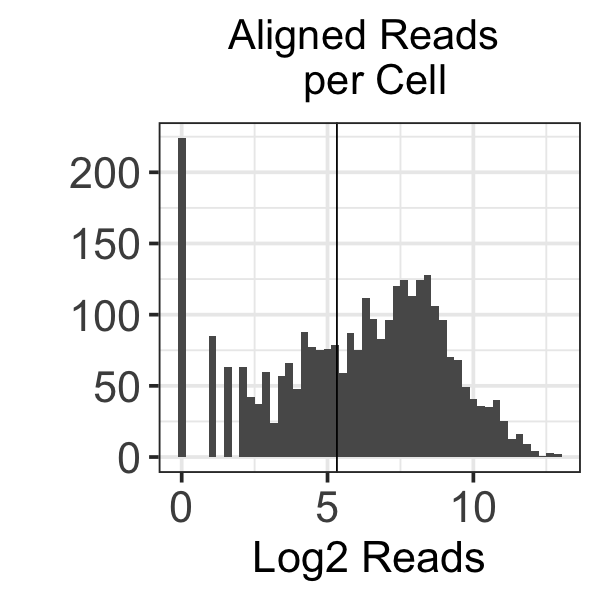

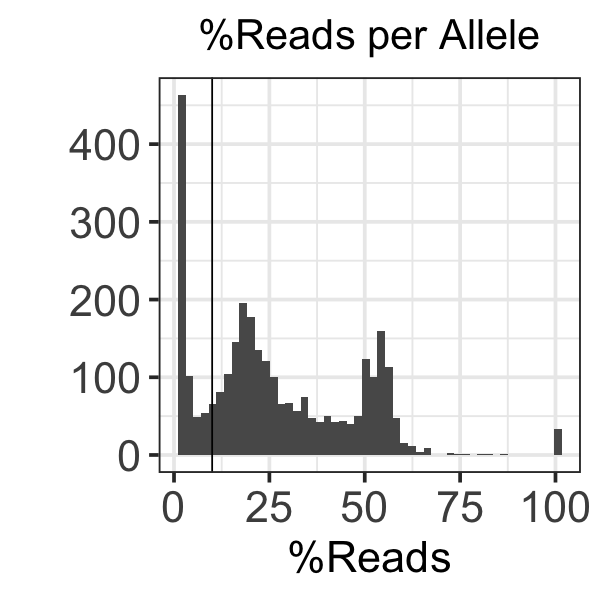

In [13]:
### DNA reads
fig.size(5,5)
alleles_DNA %>%  
    ggplot(aes(log2(`#Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = log2(40)) + 
    xlab("Log2 Reads") + ylab("") + ggtitle("Aligned Reads \n per Cell")

## AlleleFreq
fig.size(5,5) 
alleles_DNA %>% 
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = (10)) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [55]:
## DNA analysis, filter and identify deletion in allele 1 and allele 2

In [14]:
#Filter alleles on Reads # and Allele Freq
alleles_DNA_filt <- alleles_DNA %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12,40) 
#Merge with MetaData
alleles_DNA_filt<- separate(alleles_DNA_filt, Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% 
    inner_join(select(meta_DNA, -Reference))

Joining with `by = join_by(Plate_Well, Reference)`
Joining with `by = join_by(Barcode_DNA)`


In [15]:
#Fix lengths.
alleles_DNA_filt<- mutate(alleles_DNA_filt, 
           "Allele1" = str_trunc(Allele1, 180, "left", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 180, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))

In [17]:
## Pull out alleles and see which nucleotides are reference (should I just make this into a function?)
Allele1 <- alleles_DNA_filt$Allele1 %>% as.matrix() %>% 
apply(1, function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(alleles_DNA_filt$Allele1[1]))

Allele2 <- alleles_DNA_filt$Allele2 %>% as.matrix() %>% 
apply(1, function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(alleles_DNA_filt$Allele2[1]))

REF <- apply(matrix(alleles_DNA_filt$Reference), 1, 
        function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(alleles_DNA_filt$Reference[1]))

Allele1[Allele1 == REF]<- "R"
Allele2[Allele2 == REF]<- "R"

#replace any modification with an X
Allele1 <- apply(Allele1, 1, 
        function(x) {
            gsub("-|A|C|T|G", "X", x) })
Allele2 <- apply(Allele2, 1, 
        function(x) {
            gsub("-|A|C|T|G", "X", x) })

## combine back into a single string
alleles_DNA_filt_alt <- copy(alleles_DNA_filt)
alleles_DNA_filt_alt$Allele1 <- apply(Allele1, 2, paste, collapse="") 
alleles_DNA_filt_alt$Allele2 <- apply(Allele2, 2, paste, collapse = "")

#Combine into alleles and call genotypes
alleles_DNA_filt_alt_gen <- GenotypesFunction(alleles_DNA_filt_alt)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Joining with `by = join_by(Alleles)`


In [21]:
#Separate by nucleotide position
ALLELES <- apply(matrix(alleles_DNA_filt_alt_gen$Alleles), 1, 
        function(x) {
            gsub("(.{2})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(alleles_DNA_filt_alt_gen$Alleles[1])/2)

#Create Deletion Matrix and make numeric.
DeletionMatrix <- apply(ALLELES, 1, 
        function(x) {
            gsub("RR", 0, x) }) %>% 
apply(1, function(x) {
            gsub("RX|XR", 1, x) }) %>% 
apply(1,function(x) {
            gsub("XX", 2, x) })  
DeletionMatrix<- DeletionMatrix %>% apply(1, as.numeric)

### Pull out and add cell IDs to matrix (from FlowMatrix)
DeletionMatrix<- alleles_DNA_filt_alt_gen %>% dplyr::rename(Well_ID = Well) %>% 
inner_join(select(FlowMatrix, Well_ID, Barcode_DNA, cell)) %>%
select(cell) %>% cbind(DeletionMatrix)

Joining with `by = join_by(Barcode_DNA, Well_ID)`


In [23]:
##Add MeanDeletionData, #filter on reads and %
DeletionMatrix<- alleles_DNA %>% filter(`#Reads` > 40 & `%Reads`>12) %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>%
    group_by(DNA_Well) %>% summarise(DQB1deletion_Mean = mean(n_deleted)) %>% as_tibble() %>% 
separate(DNA_Well, into = c("Barcode_DNA", "Well_ID")) %>% 
inner_join(read_csv("PlateMeta2Full.csv"), by = "Barcode_DNA")%>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate(cell = paste0(RNA_cell, "_", Barcode_RNA)) %>% inner_join(DeletionMatrix)

## export matrix (proceed to secondary notebook for heatmap plots)
write_csv(DeletionMatrix, "DeletionMatrix.csv")

Rows: 10 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(cell)`


## Identify HDR cells

In [38]:
#HDR cells - Corrected mutation
HDRDQB1<- alleles_DNA$Aligned_Sequence %>% grep(pattern = "GCTGATTGGTTCTTTTCCGAGCGACCATCCAAT")
HDRCells <- alleles_DNA[HDRDQB1,] %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% with(DNA_Well)

In [39]:
#Reference cells no editing of any kind detected
ReferenceCells<- alleles_DNA %>% mutate(DNA_Well = paste0(Barcode_DNA, "_", Well_ID)) %>% group_by(DNA_Well) %>% 
    summarize(editing = sum(n_deleted)+sum(n_inserted) + sum(n_mutated)) %>% filter(editing == 0) %>% 
with(DNA_Well)

In [ ]:
write.csv(ReferenceCells, "DQB1Reference.csv")
write.csv(HDRCells, "DQB1HDR.csv")

In [ ]:
### DNA reads
fig.size(5,5)
FBXO11_alleles_DNA %>% mutate("test" = paste0(Well_ID, Barcode_DNA)) %>% 
                            group_by(test) %>% summarise(test, "mean" = mean(`#Reads`)) %>% unique %>% 
    ggplot(aes(log2(mean))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = log2(40)) + 
    xlab("Log2 Reads") + ylab("") + ggtitle("FBXO11 DNA Aligned Reads \n per Cell")

In [ ]:
# Allele Freq - this is being caused by a sequencing error from too many T's 
FBXO11_alleles_DNA %>% 
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = (10)) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [ ]:
#Filter alleles
FBXO11_alleles_DNA_filt <- FBXO11_alleles_DNA %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12, 40) 
#Merge with metaData
FBXO11_alleles_DNA_filt<- 
    FBXO11_alleles_DNA_filt %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(meta_DNA)

#Fix length from P7
FBXO11_alleles_DNA_filt<- FBXO11_alleles_DNA_filt %>% 
    mutate("Allele1" = str_trunc(Allele1, 65, "left",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 65, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 65, "left", ellipsis = "")) %>% 
    mutate("Allele1" = str_trunc(Allele1, 50, "right",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 50, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 50, "right", ellipsis = ""))
#Call genotypes
FBXO11_alleles_DNA_filt_gen <- GenotypesFunction(FBXO11_alleles_DNA_filt)

In [ ]:
FBXO11_alleles_DNA_filt_gen$genotype %>% table %>% sort(decreasing = T)

In [ ]:
fig.size(5,10)
#Define order
order <- FBXO11_alleles_DNA_filt_gen$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)
#Make DF for plotting
df<- GenotypeHeatmap2(FBXO11_alleles_DNA_filt_gen, 2)
#Fix order
df$genotypes <- factor(df$genotypes, levels = order)

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        geom_text(data = dplyr::filter(df, value != "R"),
                  aes(label = allele_value), angle = 0, size = (4))+
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(genotypes~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, size = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, size = 1)
plot(g)

#suppressWarnings({ 
 #   ggsave(g, filename = "FBXO11Genotypes.png", device = "png", dpi = 300)
  #  })

In [ ]:
FBXO11_alleles_DNA_filt_gen$genotype %>% 
    table %>% as.data.frame() %>% filter(Freq > 2) %>% arrange(Freq)

# Quality Control - Filtering RNA / ADT

## RNA QC

In [40]:
nUMI = colSums(exprs)
nGenes = colSums(exprs > 0)
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])

In [41]:
meta = cbind(meta, qc_df[rownames(meta), ])

In [42]:
##Add indexing flow data to meta. 
meta_Flow <- FlowMatrix %>% inner_join(meta)

Joining with `by = join_by(cell)`


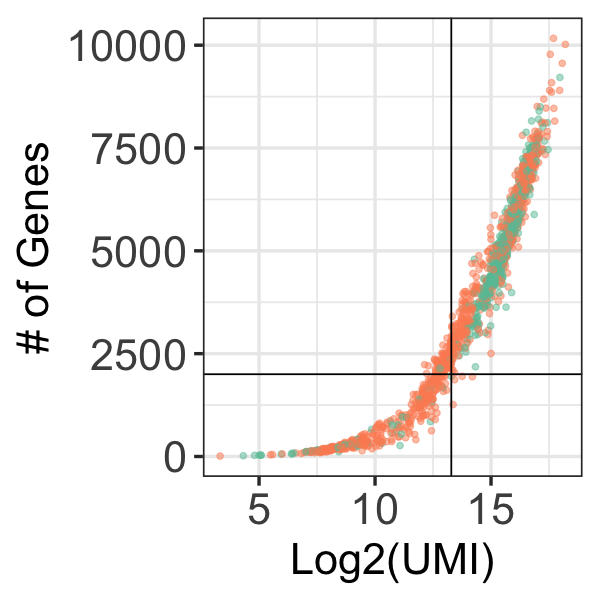

In [44]:
# QC figures
fig.size(5,5)
library(scales)
options(scipen = 999)

ggplot(meta_Flow %>% na.omit) +
       geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of Genes") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2")  + 
    theme(legend.position = "none") + 
    scale_x_continuous(labels = scales::comma) + 
    labs(color = "Celltype")+  
    geom_vline(xintercept = log2(10000)) + 
    geom_hline(yintercept = 2000)
    

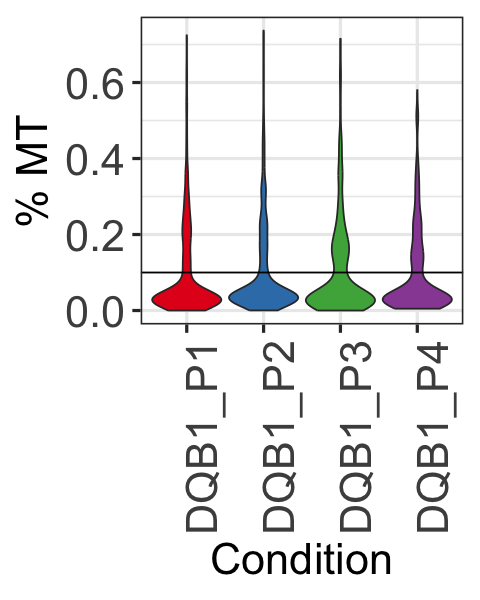

In [45]:
fig.size(5, 4)
meta_Flow %>% na.omit %>%
ggplot()+
    geom_violin(aes(x = Condition, y = pctMito, fill= Condition), scale = 'width')+
    theme_gy()+
    geom_hline(yintercept = 0.1) + 
    theme_gy(20) + ylab("% MT") + 
    scale_fill_brewer(palette = "Set1") + 
    theme(legend.position = "none")+
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

In [46]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [47]:
#Set thresholds based on above. 
nUMI_thresh =  10000 #5000 #40
nGene_thresh = 2000
pctMito_thresh = 0.1
ncell_thresh = floor(dim(exprs)[2]*0.1) #expressed in 10% of cells

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   rownames(qc_df %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh))]
#filtered expression
filt_meta = meta[colnames(filt_exprs),] #filtered meta

In [48]:
filt_cellcount = (table(meta$plate) %>% unclass %>% as.data.frame) - 
                (table(filt_meta$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

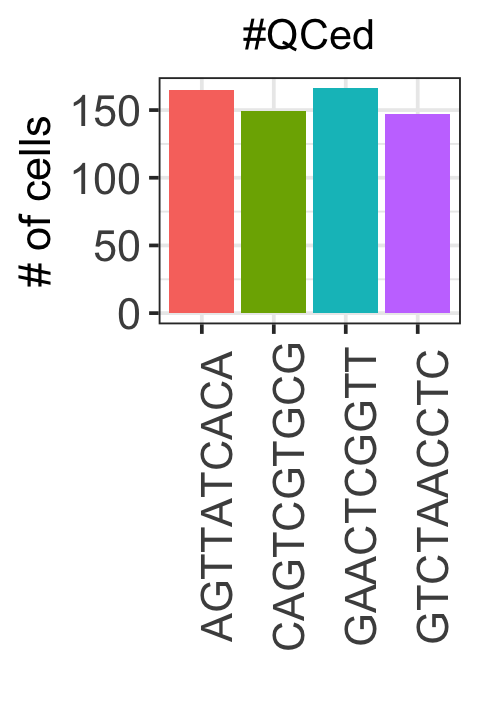

In [49]:
fig.size(6, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

## ADT QC

In [50]:
# Filter non-human ADTs and cells not called by STAR (RNA)
counts_ADT_filt <- counts_ADT[rownames(counts_ADT)[!grepl('^Mouse|^Rat|^Hamster', rownames(counts_ADT))], 
                             intersect(rownames(meta_ADT), rownames(meta))]

meta_ADT_filt <- meta_ADT[intersect(rownames(meta_ADT), rownames(meta)), ]

In [51]:
rownames(meta_ADT_filt) <- meta_ADT_filt$cell

Warning message:
“Setting row names on a tibble is deprecated.”


In [52]:
nUMI_ADT = colSums(counts_ADT_filt)
nGenes_ADT = colSums(counts_ADT_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

meta_ADT_filt = cbind(meta_ADT_filt, qc_df_ADT[rownames(meta_ADT_filt), ])

In [53]:
##Add indexing flow data to meta. First fix labels on FlowMatrix, then add cell barcode, then merge with meta
meta_ADT_Flow <- FlowMatrix %>% inner_join(meta_ADT_filt)

Joining with `by = join_by(cell)`


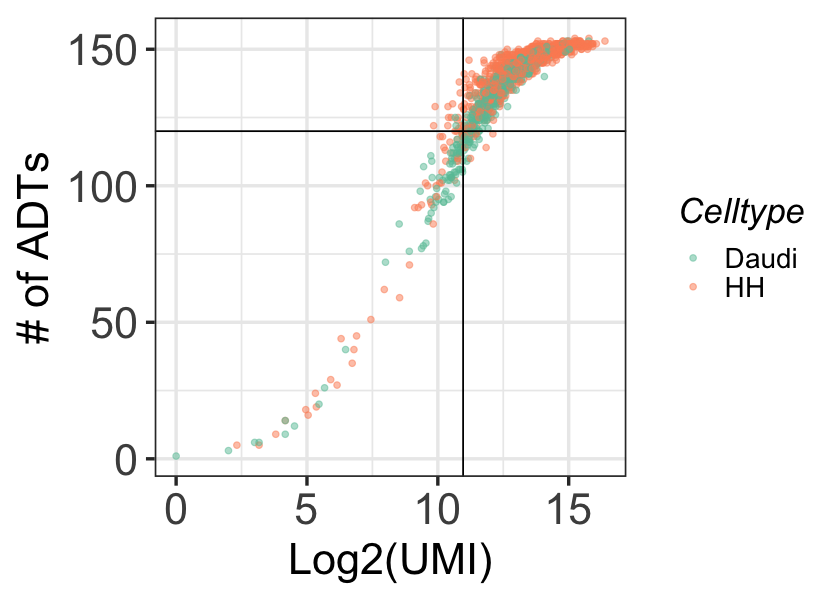

In [54]:
#plotting QC cutoffs
fig.size(5, 7)
ggplot(meta_ADT_Flow %>% na.omit) +
    geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of ADTs") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2") + 
    theme(legend.position = "right") + 
  labs(color = "Celltype")+ 
  geom_vline(xintercept = log2(2000))+
    geom_hline(yintercept = 120)
    

In [55]:
# Filter to QC'd cells only
meta_ADT_filt = meta_ADT_filt %>% filter(nUMI > 2000, nGenes > 120)
counts_ADT_filt = counts_ADT_filt[, rownames(meta_ADT_filt)]

#Intersect with mRNA data to remove low quality cells
meta_ADT_filt <- filter(meta_ADT_filt, cell %in% filt_meta$cell)
counts_ADT_filt = counts_ADT_filt[, intersect(meta_ADT_filt$cell, filt_meta$cell)]


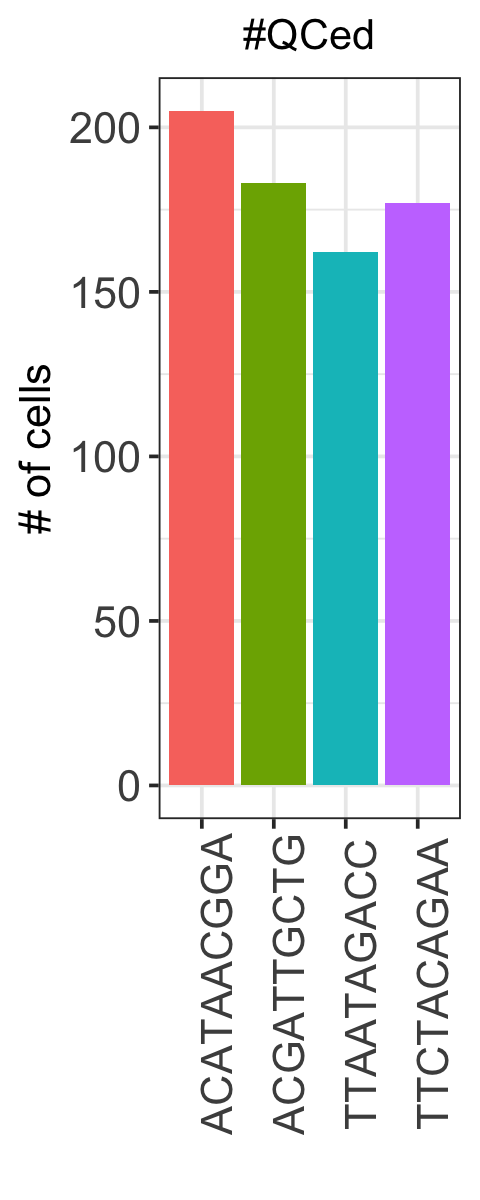

In [56]:
### Number of cells per condition/plate
filt_cellcount = (table(meta_ADT$plate) %>% unclass %>% as.data.frame) - 
                (table(meta_ADT_filt$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

### Number of cells per condition/plate

fig.size(10, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

# Pre-process expression data

In [113]:
### Pre-process based on metadata conditions

In [57]:
scale_exprs = process_rna(filt_exprs, filt_meta)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [58]:
scale_adt = process_adt(counts_ADT_filt, 
                        meta_ADT_filt)

In [59]:
# Process all genes (or a subset) without variable gene selection, useful for plotting
plot_exprs_rna = normalize_rna(filt_exprs, filt_meta, scale = TRUE)

# Dimensinoality Reduction

## RNA

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



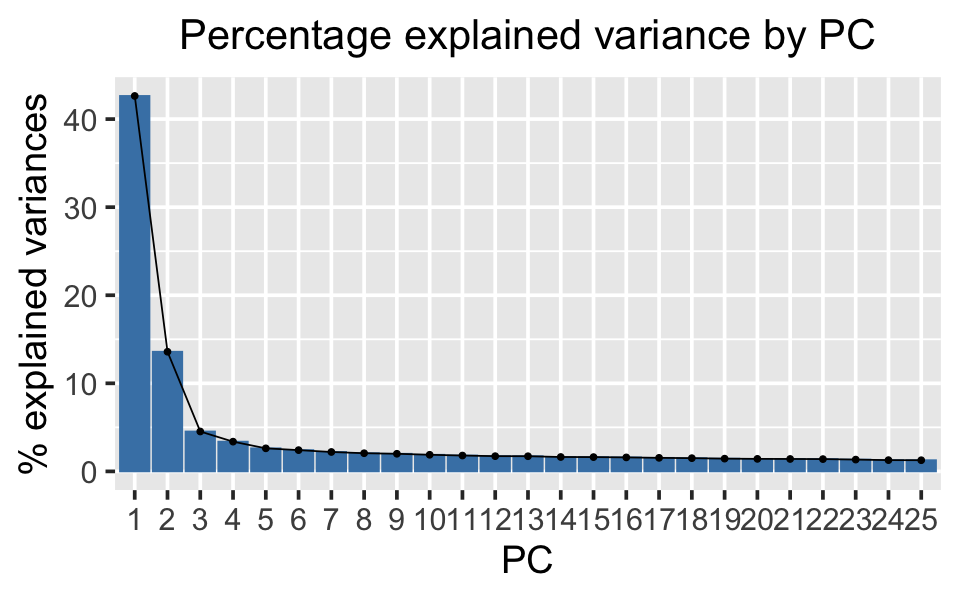

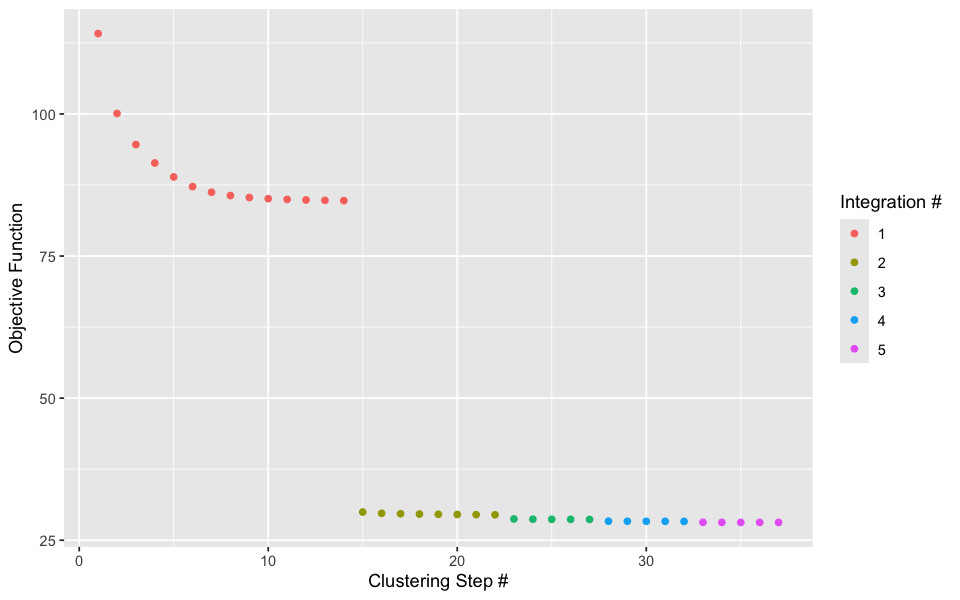

In [62]:
meta_umap = pca_umap(scale_exprs, meta, harmony_var = 'plate')

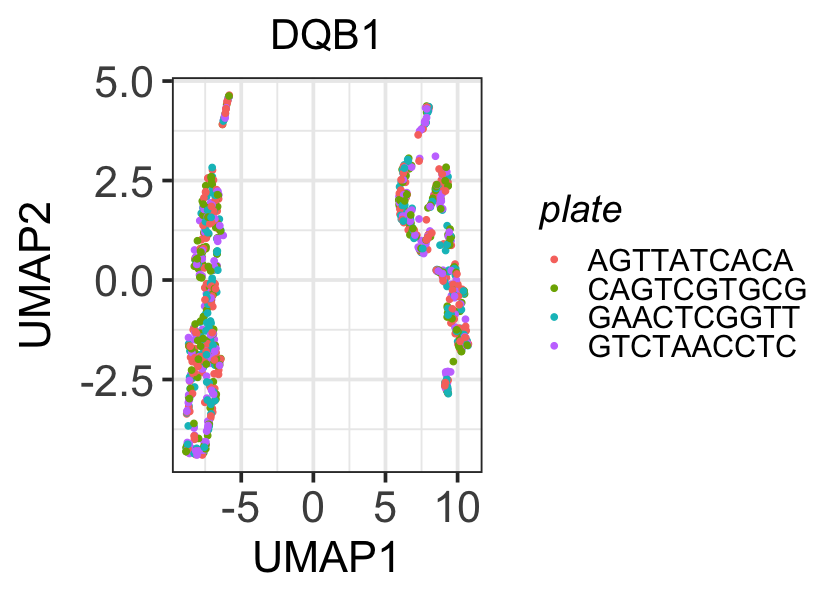

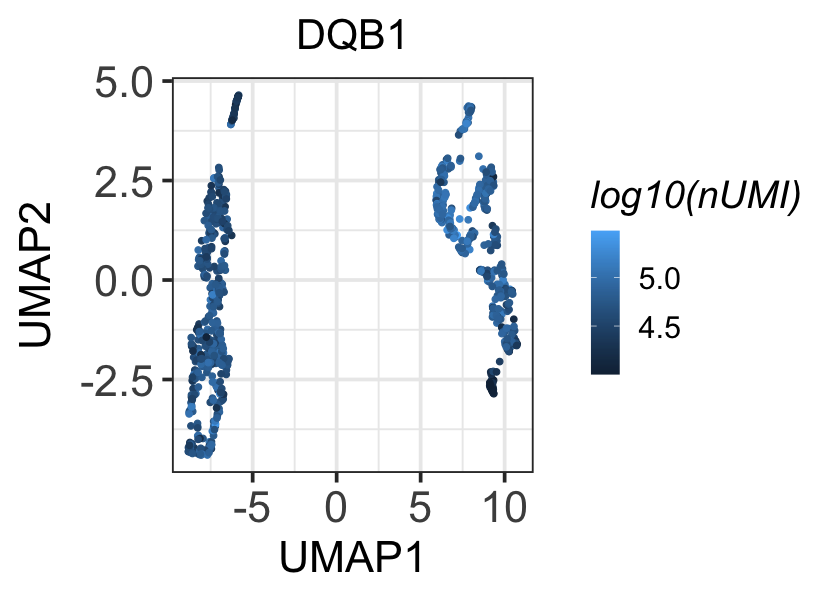

In [64]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('DQB1')
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('DQB1')

## ADT

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



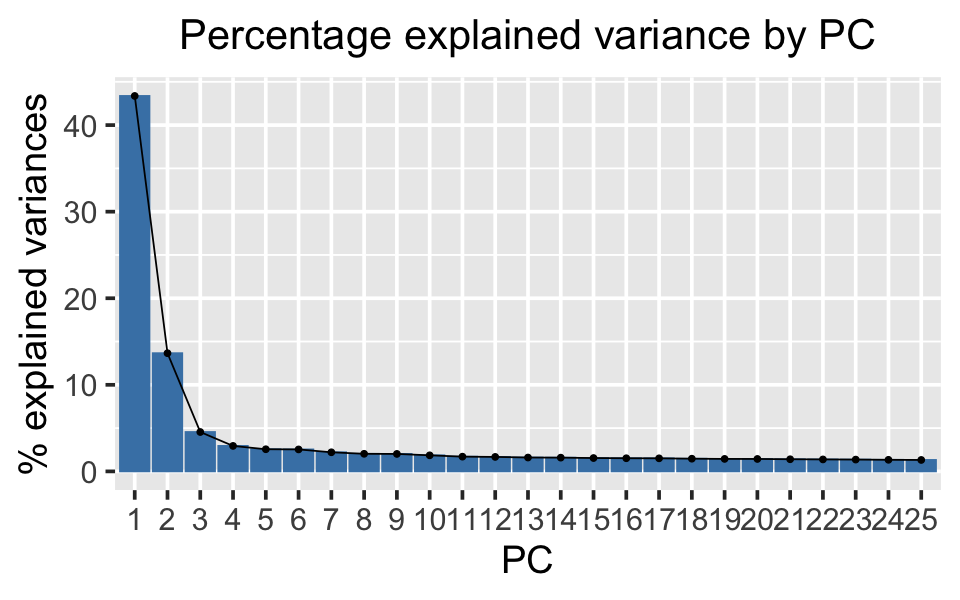

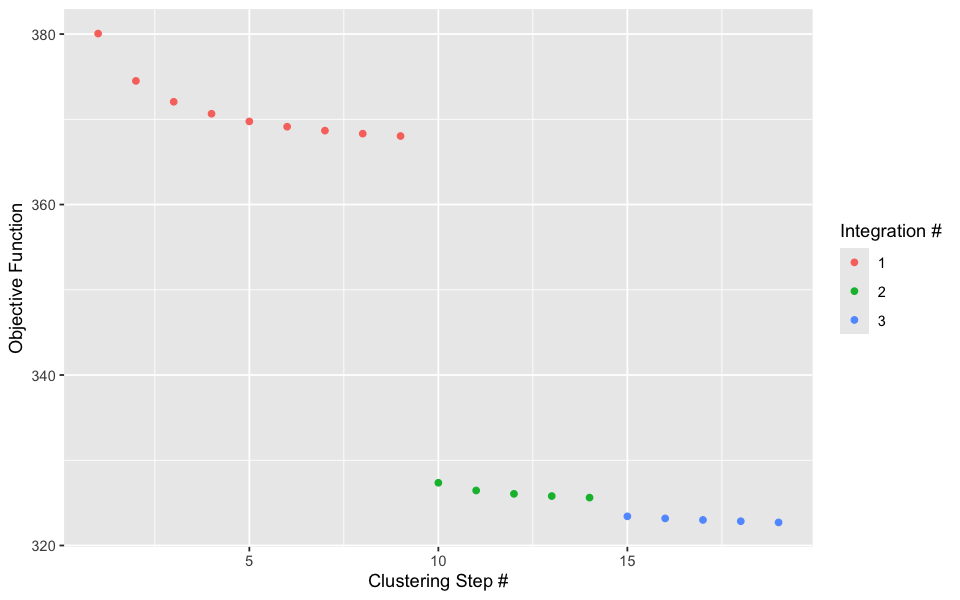

In [66]:
meta_umap_adt = pca_umap(scale_adt, meta,
                            harmony_var = 'plate')

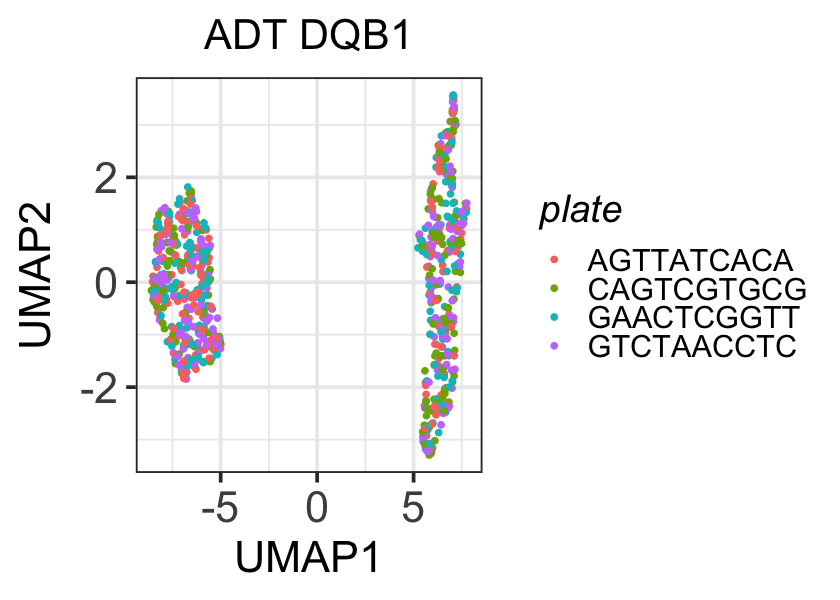

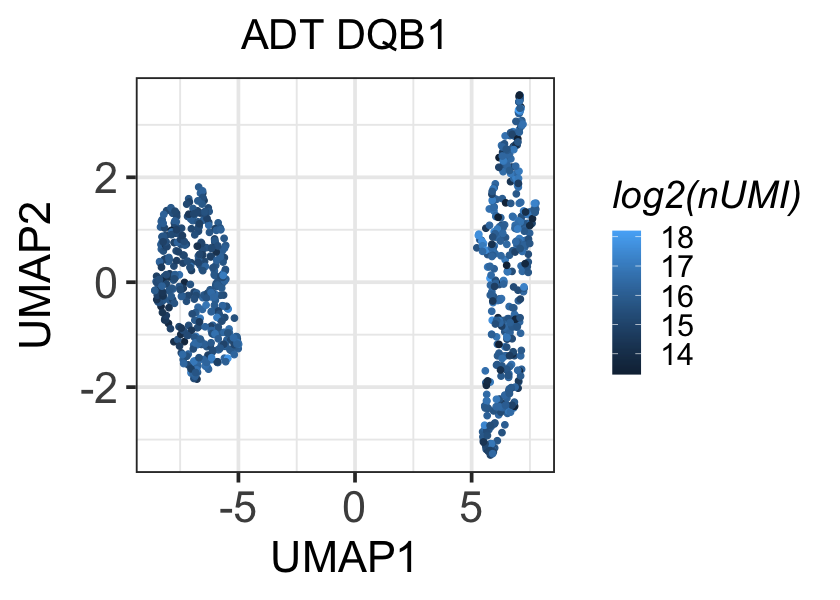

In [68]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('ADT DQB1')

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log2(nUMI)))+
    theme_gy()+
    ggtitle('ADT DQB1')

# Clustering + DGE

## RNA

In [69]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))
table(meta_umap.clust$`res.0.1`)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9749
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9498
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9254
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9029
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version


  0   1 
485 424 

In [70]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

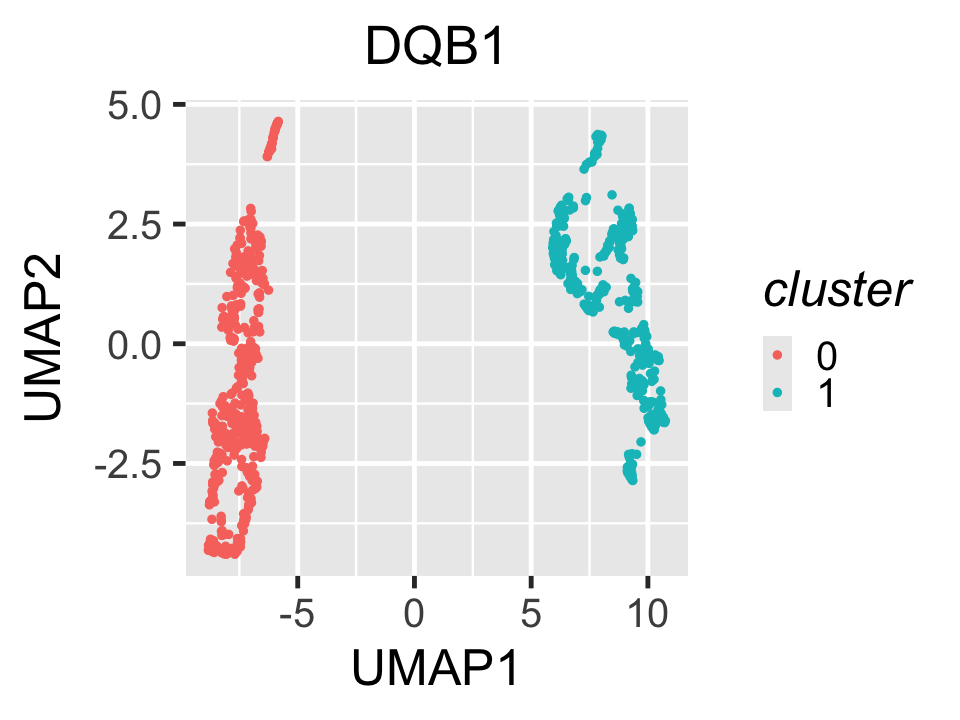

In [71]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1')

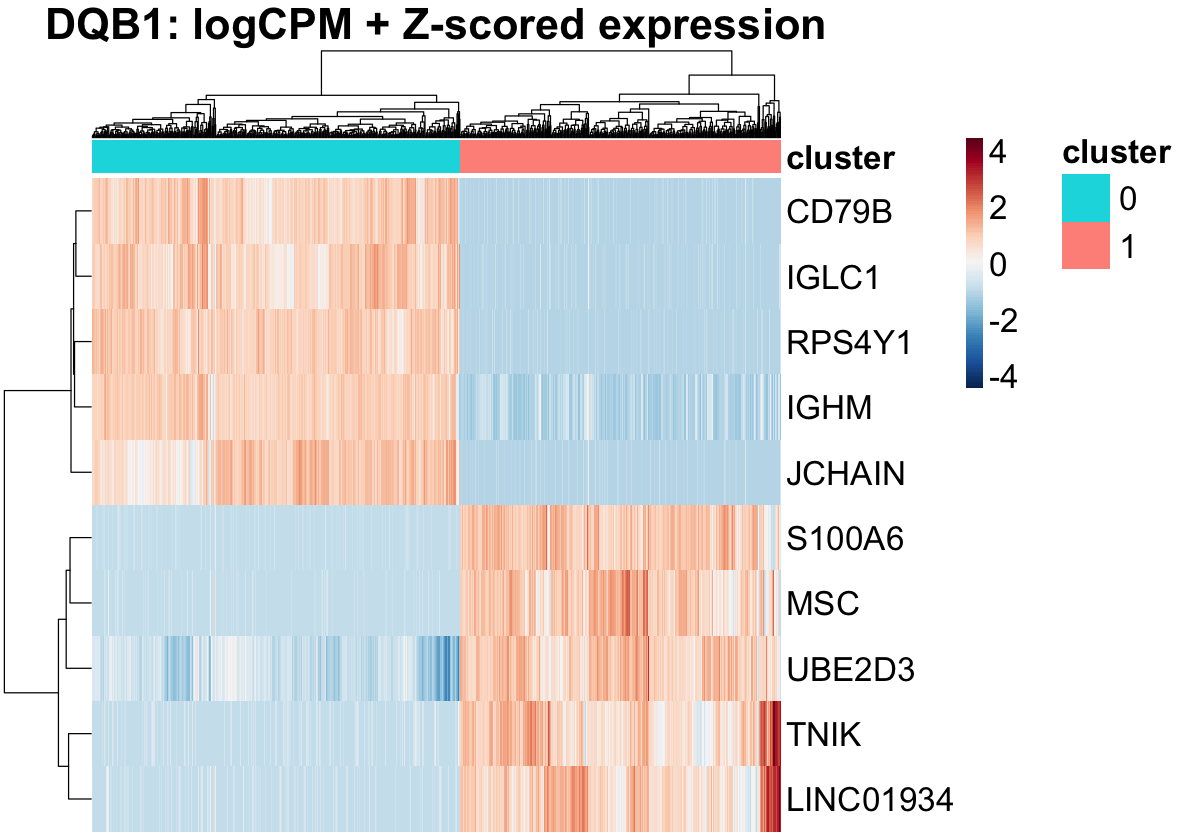

In [76]:
DGE = wilcoxauc(scale_exprs, meta_umap.clust$cluster)

var_genes = top_markers(DGE, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs[var_genes, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap.clust$cluster)
rownames(mat_col) <- rownames(meta_umap.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs[var_genes, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs[var_genes, ])))

fig.size(7, 10)
pheatmap(scale_exprs[var_genes,],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [77]:
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31867

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9491
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31867

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8989
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31867

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8590
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31867

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8228
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [78]:
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

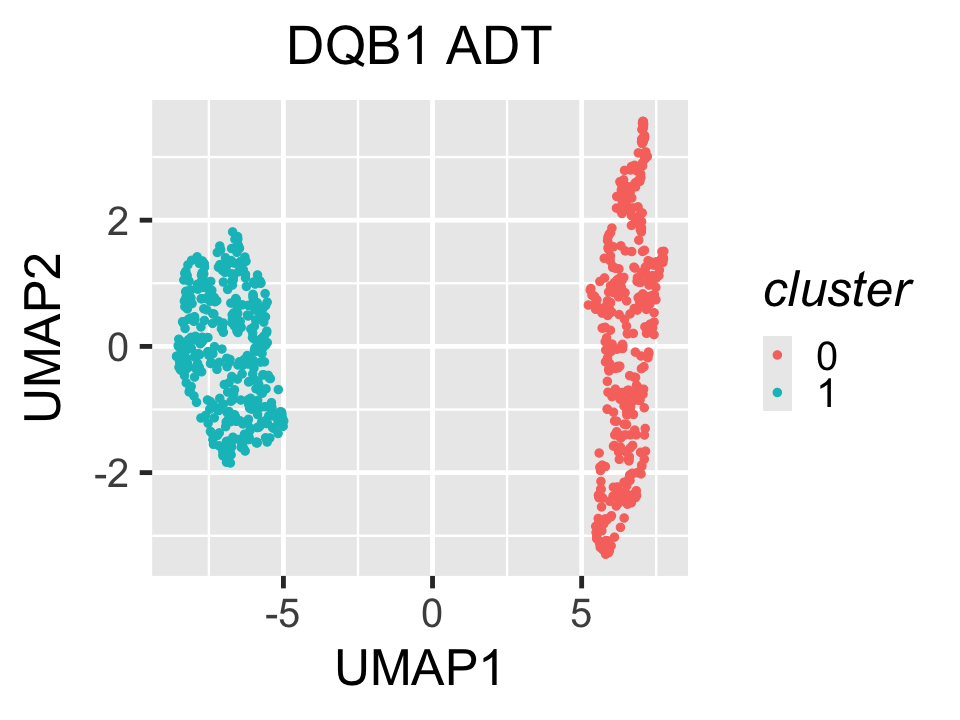

In [79]:
fig.size(6, 8)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1 ADT')

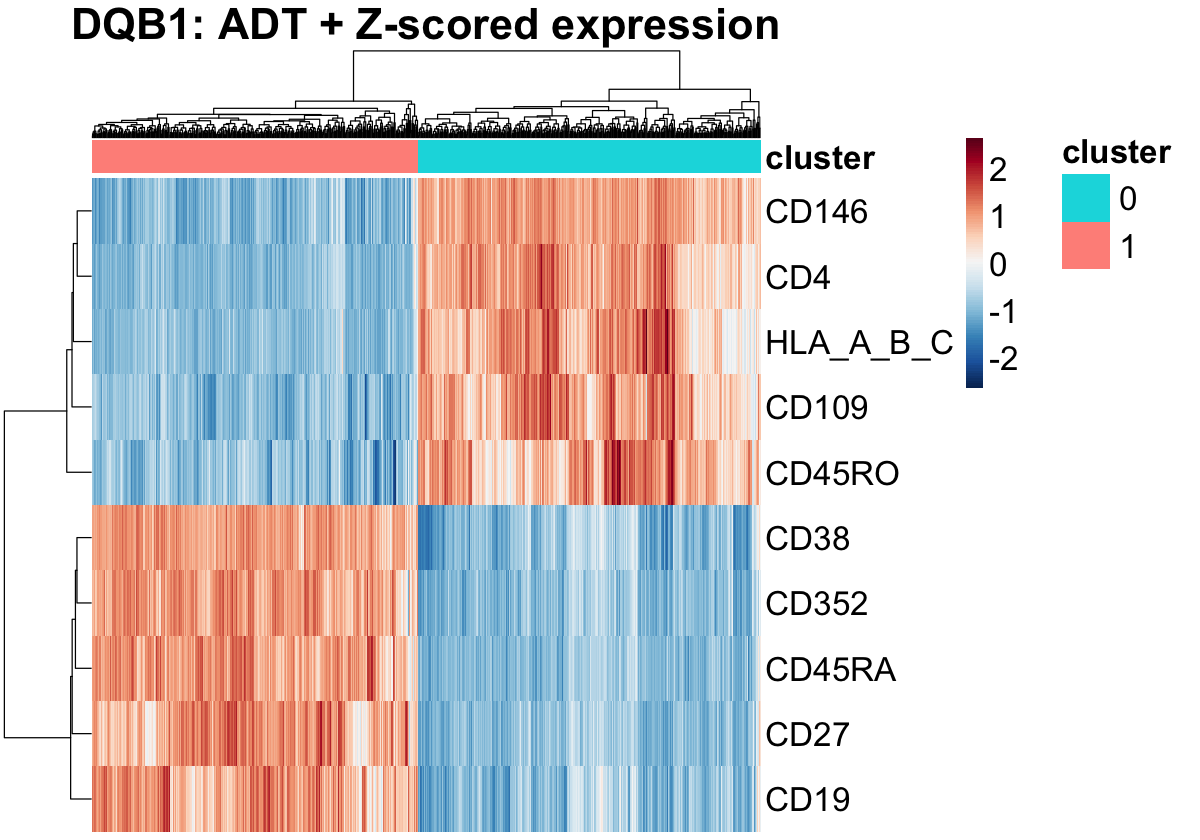

In [81]:
#Heatmap of variable adts
dge = wilcoxauc(scale_adt, meta_umap_adt.clust$cluster)
var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt[var_genes, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt[var_genes, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt[var_genes, ])))
fig.size(7, 10)
pheatmap(scale_adt[c(var_genes), ],
         main = 'DQB1: ADT + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

# Scaling and normalizing for plotting

In [83]:
#full normalized and scaled expression
filt_norm_scale_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log") %>% 
    singlecellmethods::scaleData()

In [84]:
#normalized expression
norm_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log")

In [85]:
norm_filt_exprs <- norm_exprs %>% t %>% as_tibble(rownames = "cell") 

In [86]:
CLR_adt_filt <- counts_ADT_filt%>% singlecellmethods::normalizeData(method = "cellCLR")%>% t %>% 
    as_tibble(rownames = "cell") 

# Merging Modalities 

In [92]:
##Merge all three data sets
## read in matrix from other work sheet defining clusters

Plots <- read_csv("DQB1matrix.csv") %>% select(cell, DQB1deletion_Mean, KClust, Edited_Index2) %>% 
    inner_join(select(meta_umap_adt.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes)) %>% # Add meta adt data
    inner_join(select(meta_umap.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes), by = "cell")  #add meta RNA data

##Add FlowData to this. 
Plots <- FlowMatrix %>%
    inner_join(Plots) %>% na.omit
Plots%>% head

Rows: 721 Columns: 389
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): Barcode_DNA, Well_ID.x, Condition, Barcode_RNA, Barcode_ADT, RNA_...
dbl (363): DQB1deletion_Mean, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`


Well_ID,DNA_Barcode,RNA_cell,Experiment_Index,Plate,PB_CD45,BV605_CD45,SSC,FSC,FITC_DQB1,⋯,cluster.x,UMAP1.x,UMAP2.x,nUMI.x,nGenes.x,cluster.y,UMAP1.y,UMAP2.y,nUMI.y,nGenes.y
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>
A1,AACACGAGGA,AACATCTCTGTGAC,DQB1,P1,21.28752,295.5991,6731.704,29032.91,107.4608,⋯,1,-7.999652,-0.7854007,15848,2744,0,-5.867255,4.607623,15848,2744
A2,AACCAATGAC,AACCAACCAGACTC,DQB1,P1,105.07137,995.5129,40679.443,38025.78,2236.7084,⋯,0,5.757897,1.3964585,107965,7505,1,5.946894,1.887030,107965,7505
A3,AACGACTCCA,AACCGTATGCGGTG,DQB1,P1,78.43886,634.9425,26535.552,43518.30,1333.5214,⋯,0,6.250160,1.2288128,78917,6195,1,9.046231,2.285370,78917,6195
A3,AACGACTCCA,AACCGTATGCGGTG,DQB1,P2,74.98942,1018.1517,20260.055,31765.31,378.5515,⋯,1,-6.897755,-1.7381947,88916,6578,0,-8.236022,-3.903607,88916,6578
A3,AACGACTCCA,AACCGTATGCGGTG,DQB1,P4,117.57433,236.0733,37180.267,34754.87,3064.2777,⋯,0,5.677505,-2.9220031,46599,4981,1,10.594853,-1.271620,46599,4981
A4,AACGTATACC,AACCGTGCCACATA,DQB1,P1,831.61416,433.2302,12921.952,25368.62,161.0762,⋯,1,-7.716631,1.3537875,38058,5021,0,-6.841197,-1.871044,38058,5021


## Statistical Linear Modeling with DQB1 Data. 

In [93]:
#Define cells
Daudicells <- Plots %>% filter(cluster.x == 1) %>% with(cell)
HHcells <- Plots %>% filter(cluster.x == 0) %>% with(cell)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


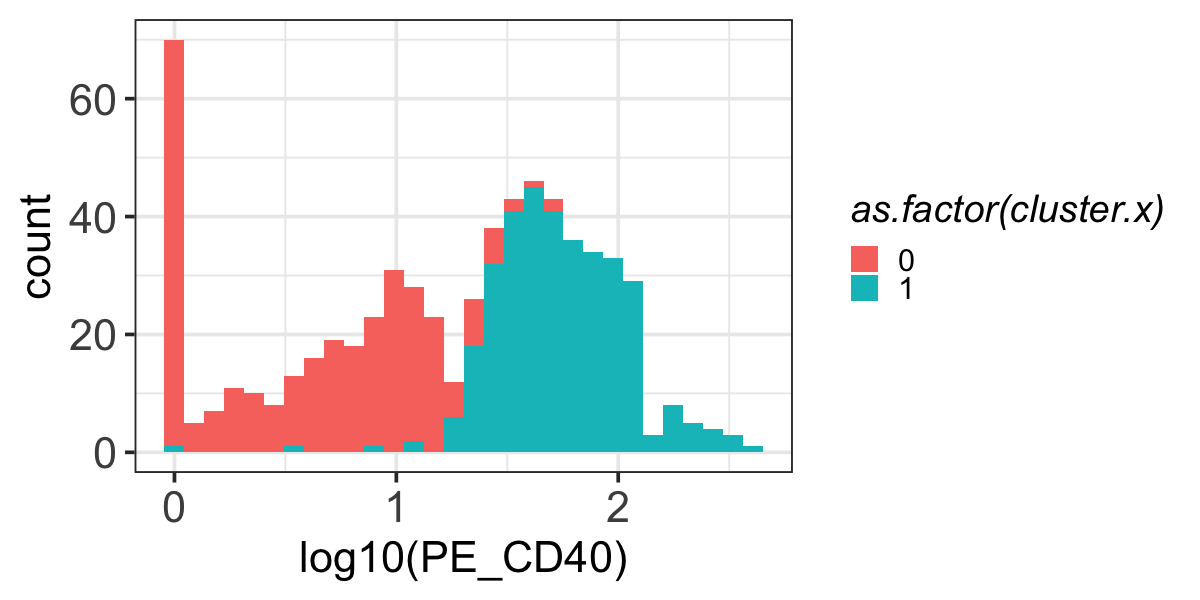

In [94]:
#Sanity check on CD40 expression (only on Daudis)
fig.size(5,10)
Plots %>% ggplot(aes(log10(PE_CD40), fill = as.factor(cluster.x))) + geom_histogram() + theme_gy()


In [95]:
library(lme4)

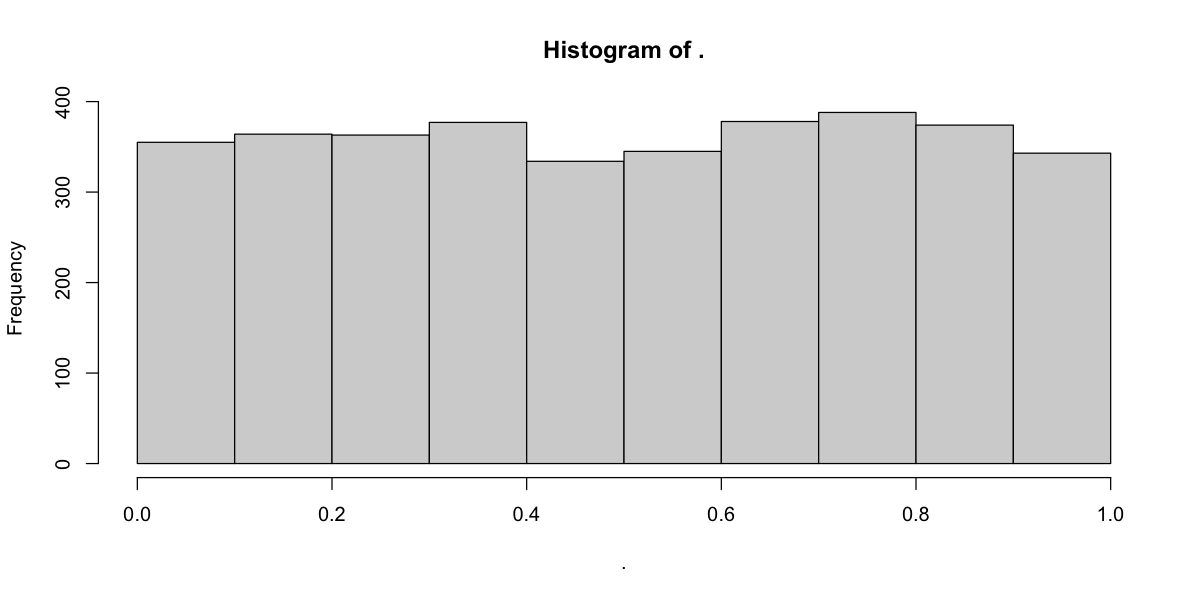

In [96]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudicells
df <- (Plots %>% filter(cluster.x == 1)) #choose Daudis

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells] #Filter on 30% expression
genes <- names(which(rowSums(Exprs)/length(cells)> 2)) # Filter on an average 2 reads per cell

#Test models of gene expression ~ to deletion size. 
suppressWarnings({
lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
lm_Daudi<- lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
lm_Daudi %>% with(pval) %>% hist
lm_Daudi <- lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

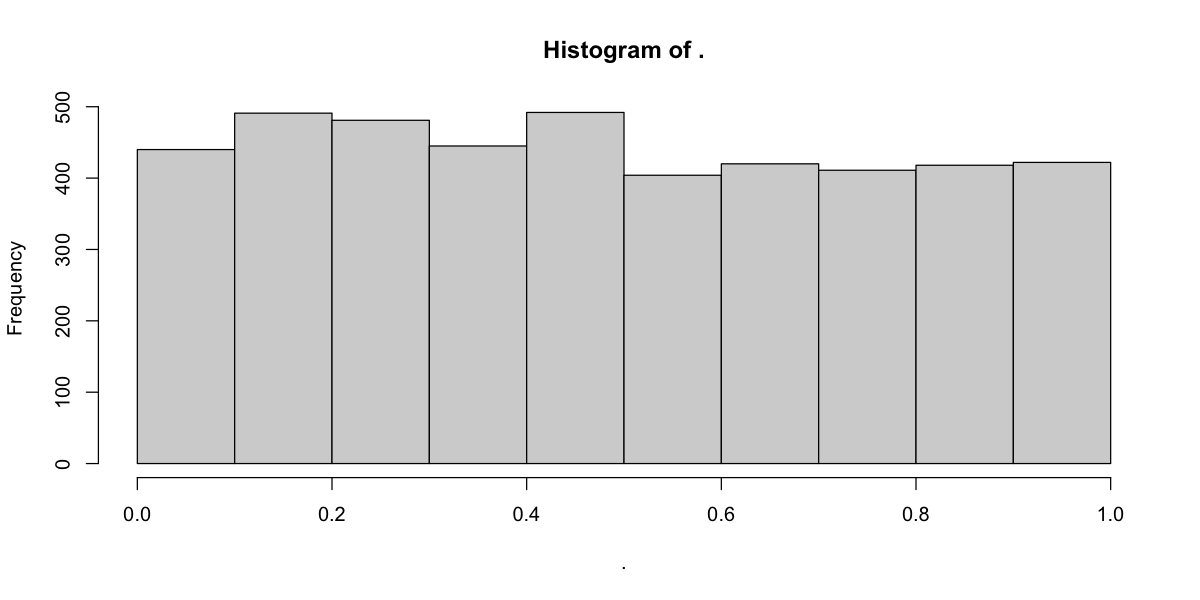

In [100]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HHcells
df <- (Plots %>% filter(cluster.x == 0)) #choose HHs

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressMessages({
    suppressWarnings({
lm_HH <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
        })
    })
lm_HH<- lm_HH %>% t %>% as_tibble(rownames = "Genes")
lm_HH %>% with(pval) %>% hist
lm_HH <- lm_HH %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudicells
df <- (DQB1Plots %>% filter(cluster.x == 1)) # Select Daudis

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
lm_Daudi_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2 #Defined based on flow cytometry. 
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
lm_Daudi_Edited<- lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
lm_Daudi_Edited %>% with(pval) %>% hist
lm_Daudi_Edited <- lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HHcells
df <- (DQB1Plots %>% filter(cluster.x == 0))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
lm_HH_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
lm_HH_Edited<- lm_HH_Edited %>% t %>% as_tibble(rownames = "Genes")
lm_HH_Edited %>% with(pval) %>% hist
lm_HH_Edited <- lm_HH_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

## Linking Genes to Locations for the Purposes of creating a manhattan plot

In [399]:
gtf <- read_tsv("mart_export.tsv")

Rows: 276950 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Gene stable ID, Transcript stable ID, Transcript name, Protein stab...
dbl (3): Gene start (bp), Gene end (bp), Strand

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [400]:
#Fixcolnames
colnames(gtf) <- c("geneID", "transcriptID", "Start", "End", "TranscriptName", "ProteinID", "Strand", "Chr", "Gene")

In [401]:
gtf_filt <- gtf %>% dplyr::select(Gene, Start, Chr) %>% unique

In [402]:
#Combine HH and Daudi results
Mix <- rbind(lm_Daudi %>% mutate("CellType" = "Daudi"),
lm_HH %>% mutate("CellType" = "HH"))

In [403]:
Mix<- Mix %>% rename(Genes = "Gene")

In [404]:
manh <- Mix %>% inner_join(gtf_filt)
manh<- manh %>% filter(Chr %in% 1:24) %>% mutate(Chr = as.numeric(Chr)) 
### do it with ggplot damnit
## filter out non numeric Chr
don <- manh %>% 
  
  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  dplyr::select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(manh, ., by=c("Chr"="Chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

Joining with `by = join_by(Gene)`
Warning message in inner_join(., gtf_filt):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 20714 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [405]:
#prepare the xaxis 
axisdf = don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )


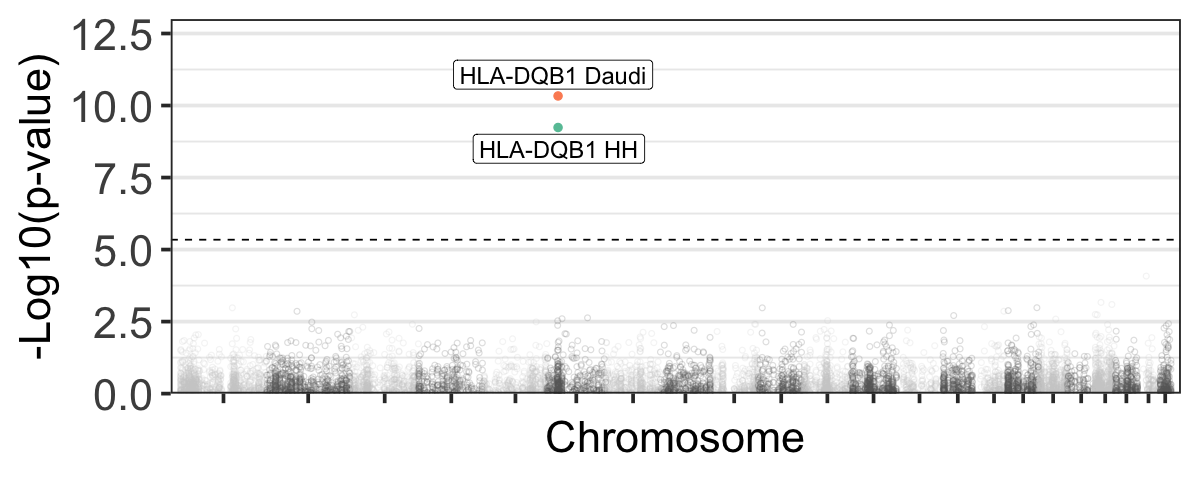

In [408]:
#define colors
colors = rep(c("grey80", "grey40"), 11 )
names(colors) = as.character(1:22)

fig.size(4,10)
g <- don %>% mutate(Gene = paste(Gene, CellType)) %>% 
{
ggplot(., aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.2, size=1.3, shape = 1) +
    scale_color_manual(values = c(colors, 
                                    "HH" = "#66C2A5", 
                                    "Daudi" = "#FC8D62"))+
    
    # custom X axis:
    scale_x_continuous(expand = c(0.01,0.01),label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(NA, -log10(10^-13))) +     # remove space between plot area and x axis
  
    # Custom the theme:
    theme_gy() +
    theme(axis.text.x =element_text(size =0, vjust = 0.5, angle = -90),
      legend.position="none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) + 
    geom_label_repel(data = filter(., pval < 0.05/6136), 
                     aes(label = Gene), size=5) + 

    geom_point(data = filter(., pval < 0.05/6136), 
                     aes(color = CellType), size=2, ) +
geom_hline(yintercept = -log10(0.05/11000), linetype = 2)+
xlab("Chromosome") + 
ylab("-Log10(p-value)")
    }
plot(g)
suppressWarnings({ggsave(g, filename = "Man.png", device="png", width = 10, height = 4) })

`geom_smooth()` using formula = 'y ~ x'


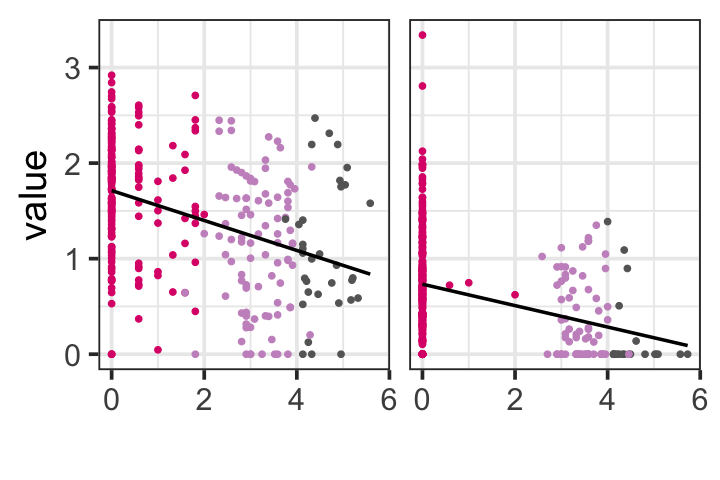

In [2548]:
#Correlations to deletion size.
fig.size(4, 6)

norm_exprs["HLA-DQB1",Plots$cell] %>% 
as_tibble(rownames = "cell") %>% inner_join(Plots, by ="cell") %>%  {

ggplot(., aes(x = log2(DQB1deletion_Mean + 1), y = value)) +  
    
geom_point(data = ., aes(color = as.factor(KClust)))  +

theme_gy()+
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "CRISPR" = "#FDBF6E",
          "1" = "#DD1C77", 
          "3" = "#C994C7",
          "2" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
    geom_smooth(method = "lm", color = "black", se =F)
             }
    